In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore", message="Found unknown categories", category=UserWarning)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,r2_score, mean_squared_error,mean_absolute_error
from xgboost.sklearn import XGBRegressor

In [86]:
df = pd.read_csv('pricing_clean.csv')

In [87]:
display(df.head(5), df.describe(include='all'), df.info(), df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4840 entries, 0 to 4839
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4840 non-null   object
 1   mileage                    4840 non-null   int64 
 2   engine_power               4840 non-null   int64 
 3   fuel                       4840 non-null   object
 4   paint_color                4840 non-null   object
 5   car_type                   4840 non-null   object
 6   private_parking_available  4840 non-null   bool  
 7   has_gps                    4840 non-null   bool  
 8   has_air_conditioning       4840 non-null   bool  
 9   automatic_car              4840 non-null   bool  
 10  has_getaround_connect      4840 non-null   bool  
 11  has_speed_regulator        4840 non-null   bool  
 12  winter_tires               4840 non-null   bool  
 13  rental_price_per_day       4840 non-null   int64 
dtypes: bool(

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
count,4840,4840.000000,4840.000000,4840,4840,4840,4840,4840,4840,4840,4840,4840,4840,4840.000000
unique,28,NaN,NaN,4,10,8,2,2,2,2,2,2,2,NaN
top,Citroën,NaN,NaN,diesel,black,estate,True,True,False,False,False,False,True,NaN
freq,968,NaN,NaN,4638,1631,1606,2660,3838,3862,3879,2610,3671,4512,NaN
mean,NaN,140826.602479,129.002066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.203099
std,NaN,58893.195228,38.930239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.484345
min,NaN,476.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,103011.250000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000
50%,NaN,141084.500000,120.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.000000
75%,NaN,175184.750000,135.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.000000


None

model_key                    0
mileage                      0
engine_power                 0
fuel                         0
paint_color                  0
car_type                     0
private_parking_available    0
has_gps                      0
has_air_conditioning         0
automatic_car                0
has_getaround_connect        0
has_speed_regulator          0
winter_tires                 0
rental_price_per_day         0
dtype: int64

## Preprocess et Basline
Nous utilisons la régression linéaire comme modèle baseline.
Ce modèle est particulièrement adapté à notre cas puisqu’il permet de prédire une variable quantitative continue (ici, le prix de location) à partir d’une ou plusieurs variables explicatives (caractéristiques du véhicule).

In [94]:
feature_list = df.drop('rental_price_per_day', axis=1)
target = df['rental_price_per_day']
X = feature_list
Y = target
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

numeric_features = ['mileage', 'engine_power']
categorical_features = ['model_key','fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning','automatic_car','has_getaround_connect','has_speed_regulator','winter_tires']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers =[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear', LinearRegression())
])
model.fit(X_train, Y_train)

# Prédictions
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

print(f"R² (train) :{ r2_score(Y_train, Y_train_pred):.2f}")
print(f"R² (test):{r2_score(Y_test, Y_test_pred):.2f}")
print(f"MAE (test):{mean_absolute_error(Y_test, Y_test_pred):.2f}")
print(f"RMSE (test):{ np.sqrt(mean_squared_error(Y_test, Y_test_pred)):.2f}")

# Cross-validation
k = 5 
kf = KFold(n_splits=k, shuffle=True, random_state=42)
scores = cross_val_score(model, X, Y, cv=kf, scoring='r2')
average_r2 = np.mean(scores) 

print(f"Average R² across {k} folds: {average_r2:.2f}")

R² (train) :0.71
R² (test):0.70
MAE (test):12.40
RMSE (test):18.39
Average R² across 5 folds: 0.70


Notre modèle d’entraînement se comporte correctement : il explique environ 71 % de la variance sur le jeu de train.
L’erreur moyenne (MAE) est de 12,40$, ce qui signifie que le modèle se trompe en moyenne de 12,40$ par rapport au prix réel.

L’écart quadratique moyen (RMSE) est plus élevé (18,39$), ce qui indique que le modèle commet des erreurs importantes sur certains cas particuliers.
En résumé, le modèle généralise assez bien, mais il a du mal à prédire correctement dans certaines conditions (probablement sur des catégories rares ou des valeurs extrêmes).
Enfin, la validation croisée (R² moyen = 0,70) confirme ces résultats et montre que le modèle est relativement robuste.

## LASSO
Le modèle LASSO (Least Absolute Shrinkage and Selection Operator) applique une régularisation L1 qui permet de réduire le sur-apprentissage.
Cette pénalisation a pour effet de contraindre certains coefficients à zéro, ce qui revient à éliminer automatiquement certaines variables jugées peu pertinentes.
Le LASSO est particulièrement utile lorsqu’on travaille avec beaucoup de variables catégorielles encodées, ce qui est le cas dans notre dataset.

In [89]:
lasso_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=42))
])

lasso_cv.fit(X_train, Y_train)

# Meilleur alpha trouvé
best_alpha = lasso_cv.named_steps['lasso'].alpha_
print("Meilleur alpha trouvé :", best_alpha)

# Prédictions
Y_test_pred = lasso_cv.predict(X_test)

# Évaluation
print(f"R² (test):{r2_score(Y_test, Y_test_pred):.2f}")
print(f"MAE (test):{mean_absolute_error(Y_test, Y_test_pred):.2f}")
print(f"RMSE (test):{ np.sqrt(mean_squared_error(Y_test, Y_test_pred)):.2f}")

Meilleur alpha trouvé : 0.020833351116249094
R² (test):0.71
MAE (test):12.45
RMSE (test):18.28


Le Lasso améliore légèrement le modèle :

R² passe de 0.70 → 0.71 

MAE passe de 12.40$ → 12.45$ 

RMSE passe de 18.39$ → 18.28$

La différence est très faible entre les deux modèles.

Le Lasso apporte un petit gain sur la robustesse (moins sensible aux grosses erreurs).

## Ridge
Ridge Regression (L2) : pénalise les coefficients en les rétrécissant mais sans les annuler.

Contrairement au Lasso, Ridge ne fait pas de sélection de variables (toutes restent dans le modèle).

In [90]:
ridge_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', RidgeCV(cv=5))
])

ridge_cv.fit(X_train, Y_train)

# Meilleur alpha trouvé
best_alpha = ridge_cv.named_steps['lasso'].alpha_
print("Meilleur alpha trouvé :", best_alpha)

# Prédictions
Y_test_pred = ridge_cv.predict(X_test)

# Évaluation
print(f"R² (test):{r2_score(Y_test, Y_test_pred):.2f}")
print(f"MAE (test):{mean_absolute_error(Y_test, Y_test_pred):.2f}")
print(f"RMSE (test):{ np.sqrt(mean_squared_error(Y_test, Y_test_pred)):.2f}")

Meilleur alpha trouvé : 1.0
R² (test):0.71
MAE (test):12.38
RMSE (test):18.26


R² passe de 0.71 → 0.71 

MAE passe de 12.45$ → 12.38$ 

RMSE passe de 18.28$ → 18.26$

Le Ridge améliore légèrement les performances sur tous les indicateurs par rapport à la baseline. Même si la différence reste modeste, Ridge est le meilleur compromis jusqu’ici.

## XGBOOST
Ce modèle est basé sur les arbres de décision. Contrairement à un arbre unique, XGBoost construit une suite d’arbres : chaque nouvel arbre vient corriger les erreurs des arbres précédents.
À la fin, les prédictions de tous ces arbres sont combinées pour former un modèle plus robuste et plus précis.

In [91]:
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgboost', XGBRegressor(random_state=42))
])
xgb.fit(X_train,Y_train)
Y_test_pred = xgb.predict(X_test)

# Évaluation
print(f"R² (test):{r2_score(Y_test, Y_test_pred):.2f}")
print(f"MAE (test):{mean_absolute_error(Y_test, Y_test_pred):.2f}")
print(f"RMSE (test):{ np.sqrt(mean_squared_error(Y_test, Y_test_pred)):.2f}")


R² (test):0.77
MAE (test):10.92
RMSE (test):16.28


Les premiers résultats du XGBoost surpassent largement ceux des modèles linéaires.
Ce modèle capture mieux les relations non linéaires et les interactions entre variables, ce qui lui permet d’obtenir des prédictions plus précises et de réduire les erreurs importantes.
Nous allons maintenant optimiser ses hyperparamètres à l’aide d’un GridSearchCV afin d’en tirer le meilleur parti.

In [92]:
# GridSearch
param_grid = {
    'xgboost__max_depth': [3, 5, 7],
    'xgboost__learning_rate': [0.01, 0.1, 0.3],
    'xgboost__n_estimators': [100, 200, 500]
}


grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=3,
    n_jobs=-1  
)

grid_xgb.fit(X_train, Y_train)

print("Meilleurs paramètres:", grid_xgb.best_params_)

Y_test_pred = grid_xgb.best_estimator_.predict(X_test)

print(f"R² (test): {r2_score(Y_test, Y_test_pred):.2f}")
print(f"MAE (test): {mean_absolute_error(Y_test, Y_test_pred):.2f}")
print(f"RMSE (test): {np.sqrt(mean_squared_error(Y_test, Y_test_pred)):.2f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 2/5] END xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estimators=100;, score=-728.676 total time=   0.1s
[CV 5/5] END xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estimators=100;, score=-488.118 total time=   0.1s
[CV 2/5] END xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estimators=200;, score=-579.873 total time=   0.2s
[CV 1/5] END xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estimators=200;, score=-407.151 total time=   0.2s
[CV 3/5] END xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estimators=100;, score=-580.035 total time=   0.1s
[CV 4/5] END xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estimators=100;, score=-499.471 total time=   0.1s
[CV 3/5] END xgboost__learning_rate=0.01, xgboost__max_depth=5, xgboost__n_estimators=100;, score=-503.090 total time=   0.2s
[CV 5/5] END xgboost__learning_rate=0.01, xgboost__max_d

Le R² passe de 0.77 → 0.77 => stable et donc superieur au modèle linéaire.

Le MAE s'améliore légèrement 10.92 → 10.53$ => encore plus précis

Le RMSE baisse également 16.28 → 16.21$ => légère meilleur gestion des grosses erreurs

Le XGBoost est le meilleur modèle. Son optimisation a permis de réduire légèrement l'erreur moyenne(MAE) et le RMSE.

<Figure size 1000x600 with 0 Axes>

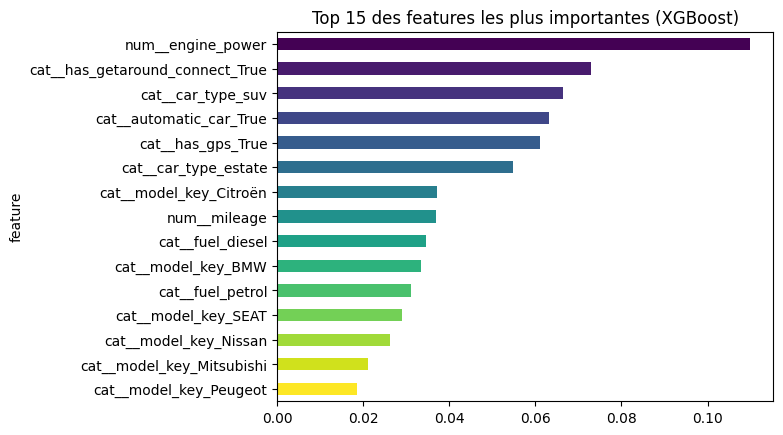

In [ ]:
xgb_best = grid_xgb.best_estimator_.named_steps["xgboost"]
feature_names = grid_xgb.best_estimator_.named_steps["preprocessor"].get_feature_names_out()

importances = xgb_best.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

colors = cm.viridis(np.linspace(0, 1, 15))

plt.figure(figsize=(10,6))
feat_imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False, color=colors)
plt.title("Top 15 des features les plus importantes (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


## Sauvegarde du modèle et test de prédiction

In [98]:
from joblib import dump, load
xgb_best_param = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators =200, n_jobs = 1)
xgb_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgboost_best', xgb_best_param)
])
xgb_final.fit(X,Y)
xgb_best_param.save_model(r'xgb_model.json')
dump(xgb_final,r'xgb_final_pipeline.pkl')



['xgb_final_pipeline.pkl']

In [99]:
from joblib import load
import pandas as pd

# Charger le pipeline complet
xgb_loaded = load("xgb_final_pipeline.pkl")

# Exemple de prédiction avec ton X_test
y_pred = xgb_loaded.predict(X_test)

print("Prédictions :", y_pred[:10])  # affiche les 10 premières prédictions


Prédictions : [119.26207 141.88487 186.08643  87.92385 102.10483 110.32258  96.29747
 131.0298  119.39136 100.0233 ]


In [ ]:
# Exemple avec de nouvelles données
new_data = pd.DataFrame([{
    "mileage": 50000,
    "engine_power": 120,
    "model_key": "BMW",
    "fuel": "diesel",
    "paint_color": "black",
    "car_type": "sedan",
    "private_parking_available": True,
    "has_gps": True,
    "has_air_conditioning": True,
    "automatic_car": True,
    "has_getaround_connect": False,
    "has_speed_regulator": True,
    "winter_tires": False
}])

# Prédiction
prediction = xgb_loaded.predict(new_data)
print("Prix estimé de location :", prediction[0])


Prix estimé de location : 144.35872
